In [1]:
#Environment Setup
!pip install matplotlib pandas numpy scipy seaborn mne
!pip install beautifulsoup4 requests wget
!pip install h5py tables kaggle
!pip install wfdb pyEDFlib PyWavelets

     |████████████████████████████████| 6.6MB 2.8MB/s 
  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=309ff51b9723fce52f81dd101e6302e5efea470490117ad347f1e9ef53a15f67
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
     |████████████████████████████████| 102kB 2.6MB/s 
     |████████████████████████████████| 1.1MB 9.1MB/s 
     |████████████████████████████████| 163kB 18.2MB/s 
  Created wheel for wfdb: filename=wfdb-2.2.1-cp36-none-any.whl size=100368 sha256=812686e486b18949e85de9d3330141efb0b401b17c257d22faca8e4433bbdb3c
  Stored in directory: /root/.cache/pip/wheels/bb/a9/00/0078d26b0c15b31be0001af8eb659496709c361c69641303f1
  Created wheel for pyEDFlib: filename=pyEDFlib-0.1.17-cp36-cp36m-linux_x86_64.whl size=926948 sha256=25d28d569f1b563979c14ec68d02ac8ac918c62f577d58a2529d87eef86160c8
  Stored in directory: /root/.cache/pip/wheels/f8/f2/6b/ce6178c882779963f57d9764c3

In [0]:
import glob            # for file locations
import pprint          # for pretty printing
import re

# colours for printing outputs
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

pp = pprint.PrettyPrinter()

def file_list(folder_path, output=False):
    # create an empty list
    file_list = []
    # for file name in the folder path...
    for filename in glob.glob(folder_path):
        # ... append it to the list
        file_list.append(filename)
        
    # sort alphabetically
    file_list.sort()
    
    # Output
    if output:
        print(str(len(file_list)) + " files found")
        pp.pprint(file_list)
    
    return file_list

**Epileptologie**


In [3]:
import sys
import os
from bs4 import BeautifulSoup
import requests
import re
import wget
import zipfile
import pandas as pd     # dataframes


def find_files(url):
    # get a soup of the directory url
    soup = BeautifulSoup(requests.get(url).text, features="html.parser")

    # make a list of all the links in the url
    hrefs_list = []
    for link in soup.find_all('a'):
        hrefs_list.append(link.get('href'))

    return hrefs_list
    
    
def download_file(download_file_url, file_dir, output=False):
    if output:
        # print it is downloading
        print('Downloading: '+ download_file_url)
    # download the file to the directory
    wget.download(download_file_url, file_dir)


def data_load(file_path, output=False):

    # read in the datafile
    data = pd.read_csv(file_path,                 # file in
                       header=None,               # no column names at top of file
                       dtype=float)               # read data as 'floating points' (e.g. 1.0)

    if output:
        print(color.BOLD+color.UNDERLINE+'\n'+re.findall('\w\d+',file_path)[0]+color.END)
        # Output detailed information on the data
        print(color.BOLD+'\nData Information'+color.END)
        data.info()

        # Output first 5 rows and columns
        print(color.BOLD+'\nDataframe Head'+color.END)
        display(data.head())
        
    return data
    
    
# needs a directory to download it to
def download_epileptologie(DIR, output=False):
    
    # directory url
    front_url = 'http://epileptologie-bonn.de/cms/front_content.php?idcat=193&lang=3&changelang=3'
    dir_url = 'http://epileptologie-bonn.de/cms'

    hrefs_dir_list = find_files(front_url)
    
    # for each link in the directory
    for link in hrefs_dir_list:
        # download the files outside of participant folders we want
        if re.findall('zip', str(link)):
            # if the file doesnt already exist in the directory
            if not os.path.exists(os.path.join(DIR, link)):
                download_file(dir_url+'/'+str(link), DIR, output)
                zip_file_name = link.split('/')[-1]
                zip_ref = zipfile.ZipFile(os.path.join(DIR, zip_file_name), 'r')
                zip_ref.extractall(os.path.join(DIR, zip_file_name[0]))
                zip_ref.close()
                os.remove(os.path.join(DIR, zip_file_name))

DOWNLOAD_DIR = "Epileptologie Database"

if not os.path.exists(DOWNLOAD_DIR):
  os.makedirs(DOWNLOAD_DIR)
  download_epileptologie(DOWNLOAD_DIR, output=True)

else:
  print("Already Downloaded")

# get folder lists
EPIL_dir_file_list = file_list(os.path.join(DOWNLOAD_DIR, '*'), output=False)
baseline_file = os.path.join(EPIL_dir_file_list[0], 'F060.txt')
seizure_file = os.path.join(EPIL_dir_file_list[3], 'S033.txt')
baseline_df = data_load(baseline_file, output=False)
seizure_df = data_load(seizure_file, output=False)

print(color.BOLD+color.UNDERLINE+"Inter-Ictal"+color.END)
display(baseline_df.shape)
print(color.BOLD+color.UNDERLINE+"Ictal"+color.END)
display(seizure_df.shape)

Downloading: http://epileptologie-bonn.de/cms/upload/workgroup/lehnertz/Z.zip
Downloading: http://epileptologie-bonn.de/cms/upload/workgroup/lehnertz/O.zip
Downloading: http://epileptologie-bonn.de/cms/upload/workgroup/lehnertz/N.zip
Downloading: http://epileptologie-bonn.de/cms/upload/workgroup/lehnertz/F.zip
Downloading: http://epileptologie-bonn.de/cms/upload/workgroup/lehnertz/S.zip
Inter-Ictal


(4097, 1)

Ictal


(4097, 1)

**NEDC TUH EEG Seizure Corpus**

In [4]:
from getpass import getpass
import numpy as np
import pyedflib

def find_files(url, headers):
    # get a soup of the directory url
    soup = BeautifulSoup(requests.get(url, auth=(headers['user'], headers['passwd'])).text, 
                         features="html.parser")
    # make a list of all the links in the url
    hrefs_list = []
    for link in soup.find_all('a'):
        hrefs_list.append(link.get('href'))

    return hrefs_list
    
    
def download_file(download_file_url, file_path, headers, output=False):
    if output:
        # print it is downloading
        print('Downloading: '+ download_file_url)
    # download the file to the directory
    r = requests.get(download_file_url, auth=(headers['user'], headers['passwd']))
    with open(file_path, 'wb') as f:
      f.write(r.content)

# needs a directory to download it to
def download_TUH(DIR, headers, sub_dir, output=False):
    
    # directory url
    dir_url = 'https://www.isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_seizure/v1.5.0/'+sub_dir

    hrefs_dir_list = find_files(dir_url, headers)
    
    # for each link in the directory
    for link in hrefs_dir_list:
        # download the files outside of participant folders we want
        if re.findall('.xlsx|\.edf|\.tse(?!_)', str(link)):
            # if the file doesnt already exist in the directory
            if not os.path.exists(os.path.join(DIR, link)):
                download_file(dir_url+'/'+str(link), DIR+'/'+str(link), headers, output)

def tuh_data_load(data_file, selected_channels=[]):

    try:
        # use the reader to get an EdfReader file
        f = pyedflib.EdfReader(data_file)

        # get the names of the signals
        channel_names = f.getSignalLabels()
        # get the sampling frequencies of each signal
        channel_freq = f.getSampleFrequencies()
        
        # get a list of the EEG channels
        if len(selected_channels) == 0:
            selected_channels = channel_names

        # make an empty file of 0's
        sigbufs = np.zeros((f.getNSamples()[0],len(selected_channels)))
        # for each of the channels in the selected channels
        for i, channel in enumerate(selected_channels):
            try:
              # add the channel data into the array
              sigbufs[:, i] = f.readSignal(channel_names.index(channel))
            
            except:
              ValueError
              # This happens if the sampling rate of that channel is 
              # different to the others.
              # For simplicity, in this case we just make it na.
              sigbufs[:, i] = np.nan


        # turn to a pandas df and save a little space
        df = pd.DataFrame(sigbufs, columns = selected_channels)#.astype('float32')

        # get equally increasing numbers upto the length of the data depending
        # on the length of the data divided by the sampling frequency
        index_increase = np.linspace(0,
                                      len(df)/channel_freq[0],
                                      len(df), endpoint=False)

        # round these to the lowest nearest decimal to get the seconds
        #seconds = np.floor(index_increase).astype('uint16')

        seconds = index_increase
        
        # make a column the timestamp
        df['Time'] = seconds

        # make the time stamp the index
        df = df.set_index('Time')

        # name the columns as channel
        df.columns.name = 'Channel'

        return df, channel_freq[0]

    except:
        OSError
        return pd.DataFrame(), None


DOWNLOAD_DIR = "TUH Database"

if not os.path.exists(DOWNLOAD_DIR):
  os.makedirs(DOWNLOAD_DIR)

user = getpass('TUH Username: ')
key = getpass('TUH Password: ')
auth_dict = {'user': user, 'passwd': key}

download_TUH(DOWNLOAD_DIR, auth_dict, '_DOCS', output=True)

seiz_info_path = '/content/TUH Database/seizures_v32r.xlsx'
train_info = pd.read_excel(seiz_info_path, 'train')
# just want the info per file here
file_info = train_info.iloc[1:6101,1:15]
# cleans some of the names
file_info_cols = ['File No.', 'Patient', 'Session', 'File', 
                       'EEG Type', 'EEG SubType', 'LTM or Routine', 
                       'Normal/Abnormal', 'No. Seizures File', 
                       'No. Seizures/Session', 'Filename', 'Seizure Start', 
                       'Seizure Stop', 'Seizure Type']
file_info.columns = file_info_cols

# we forward fill as there are gaps in the excel file to represent the info 
# is the same as above (apart from in the filename, seizure start, seizure stop 
# and seizure type columns)
for col_name in file_info.columns[:-4]:
  file_info[col_name] = file_info[col_name].ffill()

# patient ID is an integer rather than float
file_info['Patient'] = file_info['Patient'].astype(int)

# our example events file picked from the events filename
SEIZURE_EVENTS_FILE = file_info[file_info['No. Seizures File']>0]['Filename'].iloc[20]

# we use the above to get the file directory this file is in
example_file_dir = '/'.join(SEIZURE_EVENTS_FILE.split('/')[1:-1])

# this will download all edf and event files for the selected patient
download_TUH(DOWNLOAD_DIR, auth_dict, example_file_dir, output=True)

seiz_edf_name = SEIZURE_EVENTS_FILE.split('/')[-1][:-3]+'edf'
seiz_df, seiz_freq = tuh_data_load(DOWNLOAD_DIR+'/'+seiz_edf_name)

# lets remove channels not in EEG
seiz_df = seiz_df[[channel for channel in seiz_df.columns if re.findall('EEG [A-Z]',channel)]]
# ...and remove these ones too
seiz_df = seiz_df.drop(['EEG ROC-REF','EEG LOC-REF','EEG EKG1-REF'], 1)

TUH Username: ··········
TUH Password: ··········
Downloading: https://www.isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_seizure/v1.5.0/_DOCS/seizures_types_v01.xlsx
Downloading: https://www.isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_seizure/v1.5.0/_DOCS/seizures_v32r.xlsx
Downloading: https://www.isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_seizure/v1.5.0/edf/train/01_tcp_ar/008/00000883/s002_2010_09_01/00000883_s002_t000.edf
Downloading: https://www.isip.piconepress.com/projects/tuh_eeg/downloads/tuh_eeg_seizure/v1.5.0/edf/train/01_tcp_ar/008/00000883/s002_2010_09_01/00000883_s002_t000.tse


**Filtering**

**FIR FILTERS**

Without & With Windowing

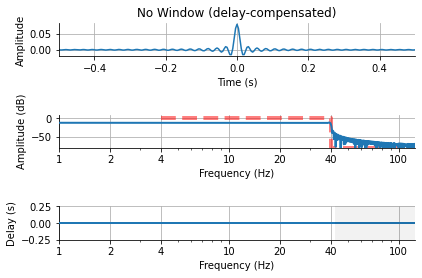

In [5]:
from mne.viz import plot_filter, plot_ideal_filter
import matplotlib.pyplot as plt

sfreq = 250
f_p = 40.
nyq = sfreq / 2.  # the Nyquist frequency is half our sample rate
freq = [0, f_p, f_p, nyq]
gain = [1, 1, 0, 0]

n = int(round(1 * sfreq))
n -= n % 2 - 1  # make it odd
t = np.arange(-(n // 2), n // 2 + 1) / sfreq  # center our sinc
h = np.sinc(2 * f_p * t) / (4 * np.pi)
flim = (1., sfreq / 2.)
fig = plot_filter(h, sfreq, freq, gain, 'No Window', flim=flim, compensate=True)

textstr = '\n'.join((
    'Pass-band Frequency: '+str(f_p),
    'Filter Length: 1s'))

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
fig.text(0.7, 0.9, textstr, fontsize=14, bbox=props)

plt.show()
fig.savefig('ringing_40hz.png')

To avoid ringing in no windowed FIR filtering, we use windowed FIR filter. We create a transition bandbetween the pass band(e.g. 40Hz) and the stop frequency(e.g. 50Hz). ALso, the shorter the filter, the wider the transition band should be to avoid ringing effects.

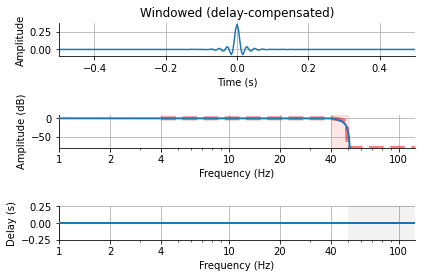

In [6]:
from scipy import signal
trans_bandwidth = 10  # 10 Hz transition band
f_s = f_p + trans_bandwidth

freq = [0., f_p, f_s, nyq]
gain = [1., 1., 0., 0.]
h = signal.firwin2(n, freq, gain, nyq=nyq)
fig = plot_filter(h, sfreq, freq, gain, 'Windowed',
                  flim=flim, compensate=True)

textstr = '\n'.join((
    'Pass-band Frequency: '+str(f_p),
    'Filter Length: 1s',
    'Transition Bandwidth: '+str(trans_bandwidth)+' Hz'))

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
fig.text(0.7, 0.88, textstr, fontsize=14, bbox=props)

plt.show()
fig.savefig('no_ringing_40hz.png')

Creating RawArray with float64 data, n_channels=23, n_times=400250
    Range : 0 ... 400249 =      0.000 ...  1600.996 secs
Ready.


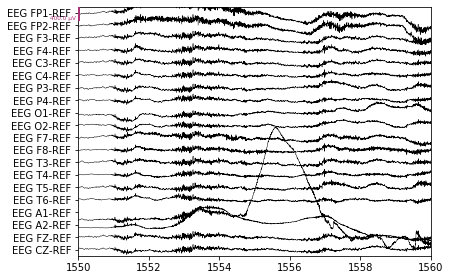

In [8]:
import mne

def mne_object(data, freq):
  # create an mne info file with meta data about the EEG
  info = mne.create_info(ch_names=list(data.columns), 
                         sfreq=freq, 
                         ch_types=['eeg']*data.shape[-1])
  
  # data needs to be in volts rather than in microvolts
  data = data.apply(lambda x: x*1e-6)
  # transpose the data
  data_T = data.transpose()
  
  # create raw mne object
  raw = mne.io.RawArray(data_T, info)

  return raw

tuh_mne = mne_object(seiz_df, seiz_freq)

plot = tuh_mne.plot(scalings = dict(eeg=20e-5),
                    start = 1550,
                    duration = 10,
                    show =True,
                    show_scrollbars=False)

Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 165 samples (0.660 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 165 samples (0.660 sec)



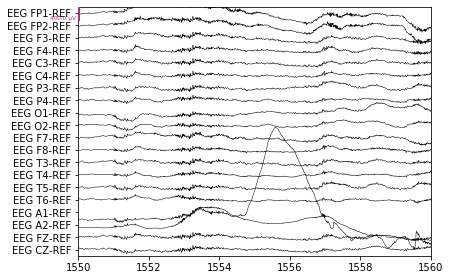

In [9]:
sfreq = tuh_mne.info['sfreq']
l_freq = None
h_freq = 40
method = 'fir'
fir_design = 'firwin2'

filter_params = mne.filter.create_filter(tuh_mne.get_data(), sfreq,
                                         l_freq=l_freq, h_freq=h_freq, 
                                         fir_design=fir_design)

filt_data = tuh_mne.filter(l_freq, h_freq,
                           method=method, 
                           fir_design=fir_design)

plot = filt_data.plot(scalings = dict(eeg=20e-5),
                      start = 1550,
                      duration = 10,
                      show =True,
                      show_scrollbars=False)

**IIR FILTERS**

Butterworth
Setting up low-pass filter at 40 Hz

IIR filter parameters
---------------------
Butterworth lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 40.00 Hz: -6.02 dB



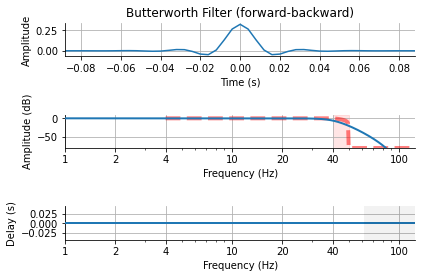

Elliptic
Setting up low-pass filter at 40 Hz

IIR filter parameters
---------------------
elliptic lowpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 40.00 Hz: -0.00 dB



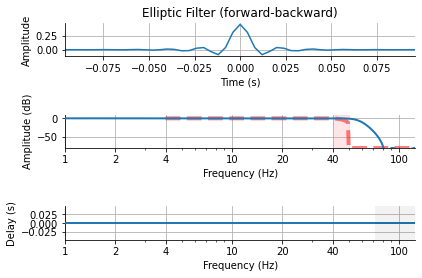

In [10]:
import mne

print(color.BOLD+color.UNDERLINE+'Butterworth'+color.END)
iir_params = dict(order=4, ftype='butter')
filt = mne.filter.create_filter(tuh_mne.get_data(), sfreq, l_freq=None, h_freq=f_p,
                                method='iir', iir_params=iir_params,
                                verbose=True)
fig=plot_filter(filt, sfreq, freq, gain, 'Butterworth Filter', flim=flim,
                compensate=True)

plt.show()

print(color.BOLD+color.UNDERLINE+'Elliptic'+color.END)

iir_params = dict(order=4, ftype='elliptic', rp=0.0025, rs=40)
filt = mne.filter.create_filter(tuh_mne.get_data(), sfreq, l_freq=None, h_freq=f_p,
                                method='iir', iir_params=iir_params,
                                verbose=True)

fig=plot_filter(filt, sfreq, freq, gain, 'Elliptic Filter', flim=flim,
                compensate=True)

**FEATURE ENGINEERING** 

**Fourier Transform**

The Fourier transform decomposes a function into its constituent frequencies. A special case is the expression of a musical chord in terms of the volumes and frequencies of its constituent notes.

[https://www.youtube.com/watch?v=spUNpyF58BY]: 3Blue1Brown Explanation


Welch Method: The Welch method is related to a Short-time Fourier transform in that it is a spectral density estimation method that calculates a periodogram for windowed sections of data. Overlapping segments are windowed, as this helps mitagate the loss of information at the edges of the time window, with a discrete Fourier transform applied to calculate the periodogram. Data is squared and each periodogram averaged to reduce the variance of each power measure.

In [11]:
from scipy.signal import welch
sample_rate = 173.61 # in hz

# specify the lowest frequency your interested in
low = 8

# this is the window size and ensures there are at least 2 cycles 
# of the lowest frequency in the window
nperseg = (2 / low)*sample_rate

# Compute the periodogram (Welch)
freqs, psd = welch(baseline_df, 
                   sample_rate, 
                   nperseg=nperseg,
                   scaling='density', 
                   axis=0)

# put into a df
psd = pd.DataFrame(psd, index = freqs, columns = baseline_df.columns)

print(color.BOLD+'Welch Output'+color.END)
psd.index.name = 'Hz'
psd.columns = ['Power']
display(psd)

Welch Output


,Power
Hz,
0.000000,889.360582
4.037442,5683.980504
8.074884,2434.988822
12.112326,840.116911
16.149767,468.925355
20.187209,200.082613
24.224651,68.433595
28.262093,27.860948
32.299535,19.928694


In [12]:
#Now we will just select the frequency range we are interested in from this output and get a mean value.
import numpy as np

# specify the higest frequency your interested in
high = 12

# Find closest indices of band in frequency vector
idx_min = np.argmax(np.round(freqs) > low) - 1
idx_max = np.argmax(np.round(freqs) > high)

# select frequencies of interest
psd = psd.iloc[idx_min:idx_max,:]

# get the mean of each channel over all frequencies in the band
psd = psd.mean()

print(color.BOLD+'\nMean Frequency Band'+color.END)
display(psd)


Mean Frequency Band


Power    1637.552866
dtype: float64

In [13]:
#Tie both parts in a function
%%time
from scipy.signal import welch
import numpy as np

def bandpower(data, sf, band, output = False):
    band = np.asarray(band)
    low, high = band

    # Compute the periodogram (Welch)
    freqs, psd = welch(data, 
                       sf, 
                       nperseg=(2 / low)*sf,
                       scaling='density', 
                       axis=0)
    
    # put into a df
    psd = pd.DataFrame(psd, index = freqs, columns = data.columns)
    
    if output:
        print(color.BOLD+'Welch Output'+color.END)
        psd.index.name = 'Hz'
        psd.columns = ['Power']
        display(psd)
    
    # Find closest indices of band in frequency vector
    idx_min = np.argmax(np.round(freqs) > low) - 1
    idx_max = np.argmax(np.round(freqs) > high)
    
    # select frequencies of interest
    psd = psd.iloc[idx_min:idx_max,:]
    
    # get the mean of each channel over all frequencies in the band
    psd = psd.mean()
    
    if output:
        print(color.BOLD+'\nMean Frequency Band'+color.END)
        display(psd)
    
    return psd

baseline_power = bandpower(baseline_df, sample_rate, [8,12], output=False)

CPU times: user 3.08 ms, sys: 0 ns, total: 3.08 ms
Wall time: 3.1 ms


Now we want to get mean values for multipule frequency bands, so we will make a function that uses the previous function in order to get these values.

In [14]:
def power_measures(data, output=False):
    bandpasses = [[[0.1,4],'power_delta'],
                  [[4,8],'power_theta'],
                  [[8,12],'power_alpha'],
                  [[12,30],'power_beta'],
                  [[30,70],'power_gamma']
                 ]
    
    welch_df = pd.DataFrame()
    for bandpass, freq_name in bandpasses:
        bandpass_data = bandpower(data, sample_rate, bandpass)
        bandpass_data.index = [freq_name]
        
        if welch_df.empty:
            welch_df = bandpass_data

        else:
            welch_df = pd.concat([welch_df, bandpass_data])
        
    welch_df = welch_df.T
    
    if output:
        display(welch_df)
    
    return welch_df

print(color.BOLD+color.UNDERLINE+'Baseline Mean Power'+color.END)
baseline_power = power_measures(baseline_df, output=True)
print()
print(color.BOLD+color.UNDERLINE+'Seizure Mean Power'+color.END)
seizure_power = power_measures(seizure_df, output=True)

Baseline Mean Power


power_delta    18864.764238
power_theta     4398.892010
power_alpha     1637.552866
power_beta       461.728763
power_gamma      124.460181
dtype: float64


Seizure Mean Power


power_delta     9811.958106
power_theta    14371.740718
power_alpha     5207.634127
power_beta      1088.598329
power_gamma      265.594331
dtype: float64

Modify this to make it work for more than 1 channel.

In [15]:
%%time
def power_measure_channels(data, freq, output=False):

  welch_df = pd.DataFrame()
  for channel_name in data:
    channel_df = pd.DataFrame(power_measures(pd.DataFrame(data[channel_name])))
    channel_df['channel'] = channel_name
    channel_df.index.name = 'feature'
    channel_df = channel_df.set_index('channel', append=True)
    channel_df = channel_df.swaplevel()

    if welch_df.empty:
        welch_df = channel_df
    else:
        welch_df = pd.concat([welch_df, channel_df])

  welch_df = welch_df.T

  if output:
    display(welch_df.head())
    
  return welch_df

example_power_measure = power_measure_channels(seiz_df, 
                                               seiz_freq, 
                                               output=True)

channel EEG FP1-REF                          ...  EEG T2-REF                       
feature power_delta power_theta power_alpha  ... power_alpha power_beta power_gamma
0        667.395217  129.775243   54.145163  ...   45.048349  10.559601    4.024451

[1 rows x 115 columns]

CPU times: user 4.07 s, sys: 22.5 ms, total: 4.09 s
Wall time: 4.11 s


**WAVELET TRANSFORM**

In [16]:
from pywt import families

families(short=False)

['Haar',
 'Daubechies',
 'Symlets',
 'Coiflets',
 'Biorthogonal',
 'Reverse biorthogonal',
 'Discrete Meyer (FIR Approximation)',
 'Gaussian',
 'Mexican hat wavelet',
 'Morlet wavelet',
 'Complex Gaussian wavelets',
 'Shannon wavelets',
 'Frequency B-Spline wavelets',
 'Complex Morlet wavelets']

In [17]:
#DWT Haar transform
from pywt import Wavelet

wavelet = Wavelet('Haar')
print(wavelet)

Wavelet haar
  Family name:    Haar
  Short name:     haar
  Filters length: 2
  Orthogonal:     True
  Biorthogonal:   True
  Symmetry:       asymmetric
  DWT:            True
  CWT:            False


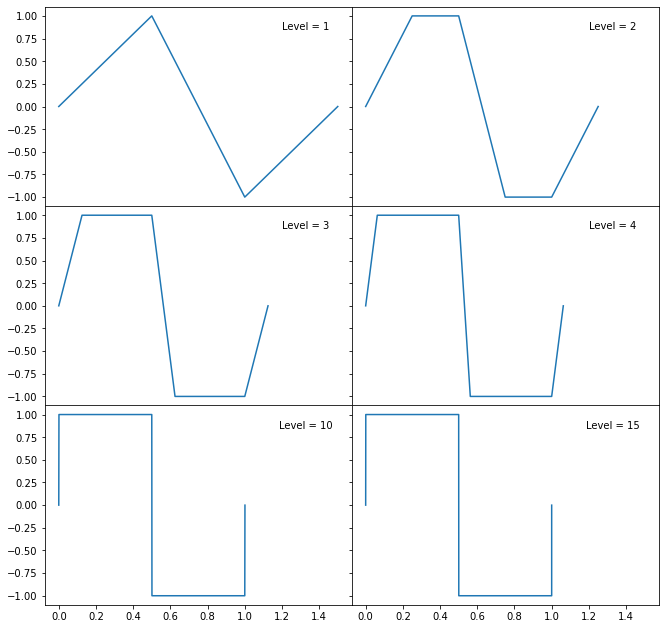

In [18]:
import matplotlib.pyplot as plt

def plot_wavelet(wavelet):

    fig, axs = plt.subplots(3,2, figsize=(11,11), squeeze =True, sharex=True, sharey=True)
    axs = axs.flatten()
    for i, level in enumerate([1, 2, 3, 4, 10, 15]):
        try:
            [psi, x] = wavelet.wavefun(level=level)
        except:
            [phi, psi, x] = wavelet.wavefun(level=level)
        axs[i].plot(x, psi)
        axs[i].text(0.85, 0.9, "Level = "+str(level), ha='center', va='center', transform=axs[i].transAxes)

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

plot_wavelet(wavelet)

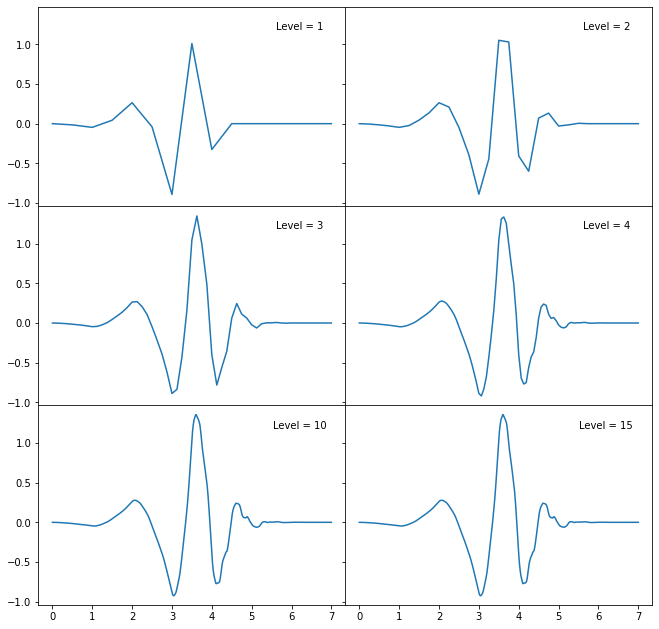

In [19]:
plot_wavelet(Wavelet('db4'))

In [20]:
from pywt import wavedec

# number of levels we are interested in
level = 6

# transpose the data because its a time-series package
data_t = baseline_df.transpose()

# get the wavelet coefficients at each level in a list
coeffs_list = wavedec(data_t.values, wavelet='db4', level=level)

print(type(coeffs_list))
print(color.BOLD+color.UNDERLINE+'\nExample first array'+color.END)
coeffs_list[0]

<class 'list'>

Example first array


array([[ 1181.70402535,  1222.31934684,  1186.58114564,  1119.30615032,
         1604.0324783 ,    25.89019047,  1780.72838765,  -973.90578049,
         1220.89183062,  1293.42816916,   969.47947677,  -157.9270515 ,
         -563.78624385,  -932.26288111,    -9.97373656, -1153.16884245,
         -388.46627896,  -978.83447438,   825.79767601, -2068.52191341,
         -902.76616695,  -907.06309716,    33.94486868,  -323.56923264,
        -1303.9367751 ,   341.99794327, -1239.81391063, -1374.40588055,
         2176.67574815,  -873.9977607 ,   136.07105931,  -576.83053461,
        -1754.71926172, -1129.91038679,  2414.20323465,  2157.9675786 ,
         2817.67685717,  -206.68406909,   418.16443435,  2386.0601948 ,
          686.29657472, -1793.06453077,  2091.92878426, -1253.63309753,
         -921.75978608, -2782.32520904,    44.8599721 , -2744.14365319,
          685.7713572 ,   444.34853778,  -540.8882925 ,  -131.68367604,
           15.37213474,  1753.78765896, -1375.40957813,  1227.31

In [21]:
# make a list of the component names (later column rows)
nums = list(range(1,level+1))
names=[]
for num in nums:
    names.append('D' + str(num))
names.append('A' + str(nums[-1]))

# reverse the names so it counts down
names = names[::-1] 

names

['A6', 'D6', 'D5', 'D4', 'D3', 'D2', 'D1']

In [22]:
# make an empty dataframe
wavelets = pd.DataFrame()

# for each array in the list of arrays
for i, array in enumerate(coeffs_list):
    # turn into a dataframe and transpose
    level_df = pd.DataFrame(array).T
    # name the column the appropriate level name
    level_df.columns = [names[i]]
    # if the wavelets df is empty...
    if wavelets.empty:
        # ... make the first level df the wavelets df
        wavelets = level_df
    # ..otherwise...
    else:
        # ... add the next levels df to another column
        wavelets = pd.concat([wavelets,level_df], axis=1)

wavelets.head()

,A6,D6,D5,D4,D3,D2,D1
0,1181.704025,-2.681982,0.645221,0.762090,-13.145503,-2.082229,1.034561
1,1222.319347,-3.841698,4.815476,5.851161,-40.035244,-7.686451,2.091650
2,1186.581146,101.168531,124.613694,49.381880,40.524474,6.152228,3.416285
3,1119.306150,-1546.522140,260.010805,-126.090877,23.713159,0.368236,18.439460
4,1604.032478,-1840.435598,443.348137,66.655876,59.011389,1.185516,5.938704


In [23]:
# remove the AN levels
regex = re.compile('D')
bad_items = [x for x in list(wavelets.columns) if not regex.match(x)]
decom_wavelets = wavelets.drop(bad_items, axis=1)

decom_wavelets.head()

,D6,D5,D4,D3,D2,D1
0,-2.681982,0.645221,0.762090,-13.145503,-2.082229,1.034561
1,-3.841698,4.815476,5.851161,-40.035244,-7.686451,2.091650
2,101.168531,124.613694,49.381880,40.524474,6.152228,3.416285
3,-1546.522140,260.010805,-126.090877,23.713159,0.368236,18.439460
4,-1840.435598,443.348137,66.655876,59.011389,1.185516,5.938704


In [24]:
%%time

def wavelet_decompose(data, output=False):
    
    # decompose data into coefficients
    level = 6

    # return the frequencies
    frequencies = np.array([seiz_freq]*level)
    j = [1<<exponent for exponent in range(level)]
    frequencies = frequencies/j
    
    # transpose the data
    data_t = data.transpose()
    
    # get the wavelet coefficients at each level in a list
    coeffs_list = wavedec(data_t.values, wavelet='db4', level=level, mode='per')

    # make a list of the component names (later column rows)
    nums = list(range(1,level+1))
    names=[]
    for num in nums:
        names.append('D' + str(num))
    names.append('A' + str(nums[-1]))
    
    # reverse the names so it counts down
    names = names[::-1] 
    
    # make an empy dataframe
    wavelets = pd.DataFrame()
    
    # for each array in the list of arrays
    for i, array in enumerate(coeffs_list):
        # turn into a dataframe and transpose
        level_df = pd.DataFrame(array).T
        # name the column the appropriate level name
        level_df.columns = [names[i]]
        # if the wavelets df is empty...
        if wavelets.empty:
            # ... make the first level df the wavelets df
            wavelets = level_df
        # ..otherwise...
        else:
            # ... add the next levels df to another column
            wavelets = pd.concat([wavelets,level_df], axis=1)
    
    # remove the AN levels
    regex = re.compile('D')
    bad_items = [x for x in list(wavelets.columns) if not regex.match(x)]
    decom_wavelets = wavelets.drop(bad_items, axis=1)
    
    if output:
        display(decom_wavelets.head())
    
    return decom_wavelets, frequencies

print(color.BOLD+color.UNDERLINE+'Baseline Wavelets'+color.END)
baseline_wavelets, frequencies = wavelet_decompose(baseline_df.iloc[:-1], output=True)
print()
print(color.BOLD+color.UNDERLINE+'Seizure Wavelets'+color.END)
seizure_wavelets, frequencies = wavelet_decompose(seizure_df.iloc[:-1], output=True)

Baseline Wavelets


,D6,D5,D4,D3,D2,D1
0,-1273.602570,-105.529467,-411.084913,-76.666336,-58.264662,2.594395
1,-1901.927267,-527.481613,233.724596,-27.684363,33.707564,-15.448868
2,-116.482456,144.051343,-194.748234,-52.546593,-17.441654,-11.257192
3,-47.260208,122.352150,1307.087703,64.925132,30.353437,13.965831
4,-2056.561156,-1192.531728,-630.414718,88.967453,-2.354381,22.606331



Seizure Wavelets


,D6,D5,D4,D3,D2,D1
0,77.459769,-2201.499253,-158.072735,81.904482,17.369233,-1.235788
1,84.452880,-473.377303,592.446067,-693.510413,3.005205,-0.680125
2,-42.688829,996.665622,-65.619967,309.412207,-12.285318,-0.702219
3,92.475661,2004.550368,-76.338451,16.967975,82.103411,-3.117101
4,-347.099179,-1154.230952,-272.987001,-59.487952,-17.700552,8.254308


CPU times: user 58.9 ms, sys: 894 µs, total: 59.8 ms
Wall time: 60 ms


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


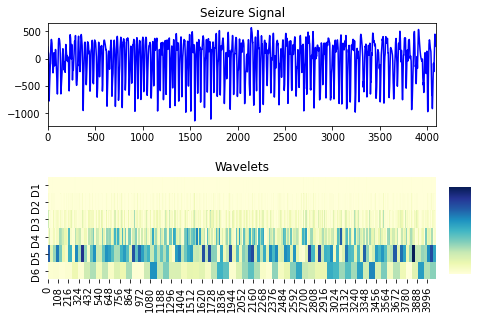

[250.     125.      62.5     31.25    15.625    7.8125]


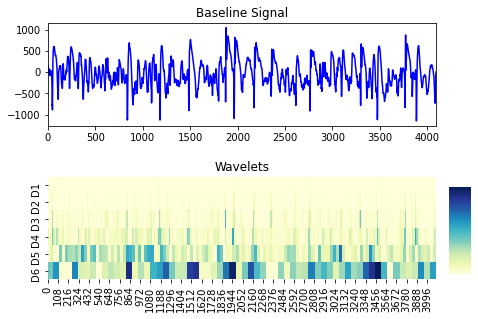

[250.     125.      62.5     31.25    15.625    7.8125]


In [25]:
import seaborn as sns

def plot_dwt_scalogram(signal, wt_data, frequencies, interpolation, class_name):
  
  cmap = plt.cm.cool
  x = range(len(signal))
  
  # Show signal and wavelet packet coefficients
  fig, (sig_ax, spec_ax) = plt.subplots(2)
  fig.subplots_adjust(hspace=0.5, bottom=.03, left=.07, right=.97, top=.92)
  
  # plot the signal
  sig_ax.set_title(class_name + " Signal")
  sig_ax.plot(x, signal, 'b')
  sig_ax.set_xlim(0, x[-1])

  exponent_list = [2<<exponent for exponent in range(wt_data.shape[1]+1)]
  wt_data_ = wt_data.copy()
  for i, decom in enumerate(wt_data.sort_index(1).columns):
    exponent_data = wt_data_[decom].dropna().repeat(exponent_list[i]).reset_index(drop=True)
    if i == 0:
      plot_data = pd.DataFrame(exponent_data.abs(), 
                               columns =[decom])
    else:
      plot_data = pd.concat([plot_data, pd.DataFrame(exponent_data.abs(), columns =[decom])], axis=1)
  
  # plot the spectrogram
  cbar_ax = fig.add_axes([1, 0.05, 0.05, 0.3])
  spec_ax.set_title("Wavelets")
  sns.heatmap(plot_data.T, ax=spec_ax, cmap="YlGnBu", cbar_ax=cbar_ax, 
              cbar_kws={"ticks":[]}
              )
  
  plt.show()
  print(frequencies)

plot_dwt_scalogram(seizure_df, 
               seizure_wavelets, 
               frequencies, None, 'Seizure')

plot_dwt_scalogram(baseline_df, 
               baseline_wavelets, 
               frequencies, None, 'Baseline')

In [26]:
from pywt import wavedec

def wavelet_decompose_channels(data, level, output=False):
  # take every x number of points using numpy's slicing (start:stop:step)
  data = data[0::2]

  data.columns.name='channel'

  # transpose the data
  data_t = data.transpose()

  # get the wavelet coefficients at each level in a list
  coeffs_list = wavedec(data_t.values, wavelet='db4', level=level)

  # make a list of the component names (later column rows)
  nums = list(range(1,level+1))
  names=[]
  for num in nums:
    names.append('D' + str(num))
  names.append('A' + str(nums[-1]))

  # reverse the names so it counts down
  names = names[::-1]  

  i = 0
  wavelets = pd.DataFrame()
  for i, array in enumerate(coeffs_list):
    # turn into a dataframe and transpose
    level_df = pd.DataFrame(array)
    level_df.index = data.columns
    level_df['level'] = names[i]
    level_df= level_df.set_index('level', append=True)
    level_df=level_df.T
    # add the next levels df to another column
    wavelets = pd.concat([wavelets,level_df], axis=1, sort=True)

  # sort values along the channels
  wavelets = wavelets.sort_values(['channel', 'level'], axis=1)

  # remove the AN levels
  regex = re.compile('D')
  bad_items = [x for x in list(wavelets.columns.levels[1]) if not regex.match(x)]
  decom_wavelets = wavelets.drop(bad_items, axis=1, level = 'level')

  decom_wavelets.index.name='sample'

  if output:
    display(decom_wavelets.head())

  return decom_wavelets

example_wavelets = wavelet_decompose_channels(seiz_df, level=5, output=True)

channel   EEG A1-REF               ...   EEG T6-REF             
level             D1           D2  ...           D4           D5
sample                             ...                          
0          -0.246493     7.473306  ...    -8.028176    27.278256
1          -0.559206    17.004884  ...   -41.323443   224.762601
2           1.076321    61.667724  ...   766.376027  3676.790720
3          65.272934  2208.515015  ... -5705.888392 -7952.029633
4        1233.859721   522.366321  ...  2329.103390  3699.779567

[5 rows x 115 columns]

DWT FEATURES
1) LOG SUM

In [27]:
#LOG SUM
def minus_small(data):    
  # find the smallest value for each data column (channel)...
  min_val = data.min()
  # ...and subtract it from all the data in the column and add one
  data = data.subtract(min_val).add(1)

  return data

def log_sum(data, output=False):
    absolute_sums = data.sum()
    # ...and subtract it from all the data in the column and add one
    absolute_sums_minus = minus_small(absolute_sums)
    # find the log of each elecment (datapoint)
    absolute_sums_log = absolute_sums_minus.apply(np.log)
    absolute_sums_log.index += '_LSWT'
    
    if output:
        display(absolute_sums_log)
    
    return absolute_sums_log
    
print(color.BOLD+color.UNDERLINE+'Baseline Log Sum Wavelets'+color.END)
baseline_LSWT = log_sum(baseline_wavelets, output=True)
print()
print(color.BOLD+color.UNDERLINE+'Seizure Log Sum Wavelets'+color.END)
seizure_LSWT = log_sum(seizure_wavelets, output=True)

Baseline Log Sum Wavelets


D6_LSWT    0.000000
D5_LSWT    9.286775
D4_LSWT    8.533138
D3_LSWT    8.726400
D2_LSWT    8.901572
D1_LSWT    8.799604
dtype: float64


Seizure Log Sum Wavelets


D6_LSWT    10.127994
D5_LSWT     0.000000
D4_LSWT    10.007185
D3_LSWT     9.042248
D2_LSWT     9.245858
D1_LSWT     9.247858
dtype: float64

In [28]:
def reformat(data, feature_name):
  data.index = [feature_name+level for level in data.index]
  data.index.name = 'feature'
  data = pd.DataFrame(data.unstack()).T

  return data

def log_sum_channels(data, output=False):
  absolute_sums = data.sum()
  # make the columns channels
  absolute_sums = absolute_sums.unstack('channel')
  # for each channel apply the minus small function
  absolute_sums_minus = absolute_sums.apply(minus_small)
  # find the log of each channel
  absolute_sums_log = absolute_sums_minus.apply(np.log)
  # reformat the df for later combination with other features
  absolute_sums_log = reformat(absolute_sums_log, 'LSWT_')

  if output:
    display(absolute_sums_log.head())

  return absolute_sums_log
    
example_absolute_sums_log = log_sum_channels(example_wavelets, output=True)

channel EEG A1-REF                      ... EEG T6-REF                   
feature    LSWT_D1   LSWT_D2   LSWT_D3  ...    LSWT_D3   LSWT_D4  LSWT_D5
0         8.927022  6.307839  5.763985  ...   7.404454  7.986045  6.62268

[1 rows x 115 columns]

In [29]:
def ave(data, output=False):
    # get the mean
    mean_data = data.mean()
    
    mean_data.index += '_mean'
    
    if output:
        display(mean_data)
    
    return mean_data
    
print(color.BOLD+color.UNDERLINE+'Baseline Mean Wavelets'+color.END)
baseline_mean = ave(baseline_wavelets, output=True)
print()
print(color.BOLD+color.UNDERLINE+'Seizure Mean Wavelets'+color.END)
seizure_mean = ave(seizure_wavelets, output=True)


Baseline Mean Wavelets


D6_mean   -113.094050
D5_mean     27.775719
D4_mean     -8.432243
D3_mean     -2.100622
D2_mean      0.102043
D1_mean     -0.296584
dtype: float64


Seizure Mean Wavelets


D6_mean    230.193912
D5_mean    -80.474188
D4_mean     46.420352
D3_mean     -3.611205
D2_mean      0.058457
D1_mean      0.039360
dtype: float64

In [30]:
def ave_channels(data, output=False):
  # get the mean
  mean_data = data.mean()

  mean_data = mean_data.unstack('channel')

  mean_data = reformat(mean_data, 'Mean_')

  if output:
      display(mean_data.head())

  return mean_data

example_wavelet_mean = ave_channels(example_wavelets, output=True)

channel EEG A1-REF                      ... EEG T6-REF                    
feature    Mean_D1   Mean_D2   Mean_D3  ...    Mean_D3   Mean_D4   Mean_D5
0         0.067999 -0.003588 -0.016376  ...   0.023377  0.150334 -0.048948

[1 rows x 115 columns]

In [31]:
def mean_abs(data, output=False):
    # get the mean of the absolute values
    mean_abs_data = data.abs().mean()
    
    mean_abs_data.index += '_mean_abs'
    
    if output:
        display(mean_abs_data)
    
    return mean_abs_data
    
print(color.BOLD+color.UNDERLINE+'Baseline Mean Absolute Wavelets'+color.END)
baseline_mean_abs = mean_abs(baseline_wavelets, output=True)
print()
print(color.BOLD+color.UNDERLINE+'Seizure Mean Absolute Wavelets'+color.END)
seizure_mean_abs = mean_abs(seizure_wavelets, output=True)

Baseline Mean Absolute Wavelets


D6_mean_abs    1181.644379
D5_mean_abs     660.597972
D4_mean_abs     280.960459
D3_mean_abs     119.135523
D2_mean_abs      32.615104
D1_mean_abs       6.904362
dtype: float64


Seizure Mean Absolute Wavelets


D6_mean_abs     700.274334
D5_mean_abs    1216.583240
D4_mean_abs     637.978335
D3_mean_abs     200.546928
D2_mean_abs      39.975884
D1_mean_abs       5.371364
dtype: float64

In [32]:
def mean_abs_channels(data, output=False):
  # get the mean of the absolute values
  mean_abs_data = data.abs().mean()

  mean_abs_data = mean_abs_data.unstack('channel')

  mean_abs_data = reformat(mean_abs_data, 'Mean_Abs_')

  if output:
    display(mean_abs_data.head())

  return mean_abs_data
    

example_mean_abs = mean_abs_channels(example_wavelets, output=True)

channel  EEG A1-REF                          ...  EEG T6-REF                        
feature Mean_Abs_D1 Mean_Abs_D2 Mean_Abs_D3  ... Mean_Abs_D3 Mean_Abs_D4 Mean_Abs_D5
0          6.376284    8.092576   18.361675  ...   17.311965   33.921945   31.842066

[1 rows x 115 columns]